## Note
-  'tasks': {'id': 'T1', 

   'type': "classical", "quantum", "hybrid"

   'need': ['GPU'],['QPU'], ['QPU', 'GPU']

   'duration': 2,
   
   'priority': 3},

In [25]:
import random
import networkx as nx

class TaskSimulator:
    def __init__(self, num_tasks=6, quantum_ratio=0.3, hybrid_ratio=0.2, max_duration=5):
        self.num_tasks = num_tasks
        self.quantum_ratio = quantum_ratio
        self.hybrid_ratio = hybrid_ratio
        self.max_duration = max_duration
        self.task_id_counter = 0

    def generate_task(self, task_type):
        self.task_id_counter += 1

        if task_type == "quantum":
            need = ["QPU"]
        elif task_type == "classical":
            need = ["CPU"] if random.random() < 0.5 else ["GPU"]
        elif task_type == "hybrid":
            classical_part = "CPU" if random.random() < 0.5 else "GPU"
            need = ["QPU", classical_part]
        else:
            raise ValueError(f"Unknown task type: {task_type}")

        return {
            "id": f"T{self.task_id_counter}",
            "type": task_type,
            "need": need,
            "duration": random.randint(1, self.max_duration),
            "priority": random.randint(1, 3),
        }

    def generate_dag(self, isolated_ratio=0.0):
        # Step 1: 生成 DAG 图
        G = nx.gn_graph(self.num_tasks, seed=None)
        G = G.reverse()

        # Step 2: 随机选一些点作为“无依赖任务”
        num_isolated = int(self.num_tasks * isolated_ratio)
        isolated_nodes = random.sample(list(G.nodes), num_isolated)

        filtered_edges = [
            (u, v) for u, v in G.edges()
            if u not in isolated_nodes and v not in isolated_nodes
        ]

        # Step 3: 任务类型分配
        classical_ratio = 1.0 - self.quantum_ratio - self.hybrid_ratio
        task_types = random.choices(
            population=["classical", "quantum", "hybrid"],
            weights=[classical_ratio, self.quantum_ratio, self.hybrid_ratio],
            k=self.num_tasks
        )

        task_map = {}
        for i in range(self.num_tasks):
            task = self.generate_task(task_types[i])
            task_map[i] = task

        return {
            "tasks": list(task_map.values()),
            "edges": filtered_edges
        }

In [28]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_dag(dag):
    G = nx.DiGraph()
    type_color_map = {"classical": "skyblue", "quantum": "lightgreen", "hybrid": "orange"}

    for i, task in enumerate(dag["tasks"]):
        task_type = task["type"]
        label = f'{task["id"]}\n{task_type}\n{"/".join(task["need"])}\n{task["duration"]}t'
        G.add_node(i, label=label, color=type_color_map.get(task_type, "gray"))

    G.add_edges_from(dag["edges"])

    pos = nx.spring_layout(G, seed=42)
    labels = nx.get_node_attributes(G, 'label')
    node_colors = [G.nodes[n]["color"] for n in G.nodes()]

    fig, ax = plt.subplots(figsize=(10, 6))
    nx.draw(
        G,
        pos,
        with_labels=True,
        labels=labels,
        node_color=node_colors,
        node_size=2000,
        font_size=8,
        edge_color='gray',
        ax=ax
    )
    ax.set_title("Task DAG (with resource and duration)")
    plt.show()


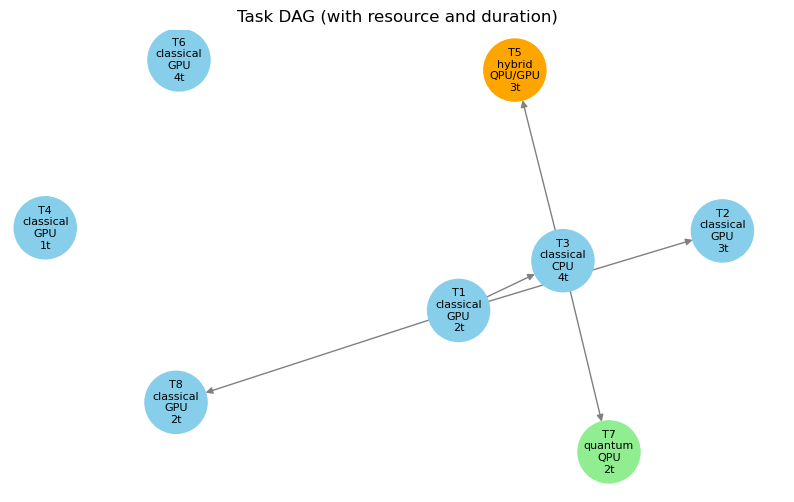

In [27]:
sim = TaskSimulator(num_tasks=8, quantum_ratio=0.3, hybrid_ratio=0.2)
dag = sim.generate_dag(isolated_ratio=0.2)
draw_dag(dag)